In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy
from scipy.linalg import cholesky, cho_solve, solve_triangular
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import GPy as gpy
import GPy
import scipy.integrate as integrate
from mpl_toolkits.mplot3d import Axes3D
import maxint_opt as opt

In [2]:
def normal(s):
    return scipy.stats.norm(0.0, np.sqrt(1.0)).pdf(s)

In [11]:
DIM = 3
LSCALE = 1.0
SDIM = 2
ADIM = 1
BETA = 2.0
ABOUNDS = [-5.0,5.0]
SBOUNDS = [-5.0,5.0]

In [12]:
def sample_function(x_range, N=100, seed=4):
#     np.random.seed(seed)
    dx = x_range.shape[1]
    k = gpy.kern.src.rbf.RBF(input_dim=dx,lengthscale=LSCALE)
    x = np.random.uniform(x_range[0], x_range[1], (N, dx))
    cov = k.K(x, x)
    mu = np.zeros(x.shape[0])
#     y = np.atleast_2d(normal(x[:,1])).T
    y = np.random.multivariate_normal(np.squeeze(mu), cov)[:, None]
    m = gpy.models.GPRegression(x, y, k)#, mean_function=mean)
    m.likelihood.variance = 0.0

    def f(x): return m.predict(x)[0]
    return f,m,x

x_range = np.array([[-5.0,-5.0,-5.0], [5.0,5.0,5.0]])
f,m,x = sample_function(x_range)


In [13]:
x = np.random.uniform(x_range[0], x_range[1], (1, DIM))
y = f(x)
gp = GPy.models.GPRegression(x, y, GPy.kern.src.rbf.RBF(input_dim=DIM,lengthscale=LSCALE),noise_var=0.0)
gps = [gp]

In [14]:
x = np.array([[0.3,0.3,0.3]])
u,v = gp.predict(x)
print u, v

def get_mean_func(gp):
    def f(x):
        Kxpx = gp.kern.K(x,gp.X)
        return np.dot(Kxpx,gp.posterior.woodbury_vector)
    return f

def get_cov_func(gp):
    def f(x,y):
        Kxy = gp.kern.K(x,y)
        K1 = gp.kern.K(x,gp.X)
        K2 = gp.kern.K(gp.X,y)
        return Kxy - K1.dot(gp.posterior.woodbury_inv.dot(K2))
    return lambda x,y: f(x,y)

print get_mean_func(gp)(x)
print get_cov_func(gp)(x,x)

[[0.00011443]] [[0.99999971]]
[[0.00011443]]
[[0.99999971]]


In [15]:
# b = np.array([0.0])
# B = np.array([[1.0]])
b = np.zeros(SDIM)
B = I = np.identity(SDIM)
gps = opt.OPT(f,gp,b,B,SDIM,ADIM,50,ABOUNDS,SBOUNDS,BETA,LSCALE)

iter 0
[0.92653766]
[[0.13226193]]
iter 1
[3.16353787]
[[-0.39778141]]
iter 2
[-1.222539]
[[-1.52504893]]
iter 3
[-4.98842948]
[[-0.0938903]]
iter 4
[4.9946225]
[[-0.20597631]]
iter 5
[-3.46599758]
[[-0.4879757]]
iter 6
[1.85115893]
[[0.28143307]]
iter 7
[1.50140577]
[[0.48271398]]
iter 8
[1.47628824]
[[0.59402585]]
iter 9
[1.42917132]
[[0.31323586]]
iter 10
[2.12810034]
[[-0.58520585]]
iter 11
[0.46882277]
[[-0.01940406]]
iter 12
[0.69047796]
[[0.10962113]]
iter 13
[-4.40045799]
[[-0.46422608]]
iter 14
[4.28602536]
[[-0.58813645]]
iter 15
[2.26032794]
[[1.45976449]]
iter 16
[2.3593993]
[[0.14531712]]
iter 17
[2.38873793]
[[0.03742745]]
iter 18
[1.21183206]
[[0.02863239]]
iter 19
[0.79821044]
[[0.3217627]]
iter 20
[1.61033373]
[[1.28512717]]
iter 21
[1.68875179]
[[0.51895858]]
iter 22
[1.73668274]
[[0.22432485]]
iter 23
[1.63433623]
[[0.25658964]]
iter 24
[1.60851226]
[[1.20460439]]
iter 25
[1.62540128]
[[-0.29542612]]
iter 26
[1.41246387]
[[0.45343264]]
iter 27
[4.99801315]
[[-0.15137

In [ ]:
gps[-1].X.shape

REFERENCE


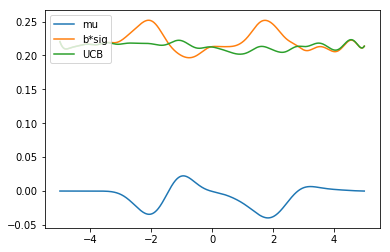

In [184]:
print "REFERENCE"
actions = np.linspace(-5.0,5.0,1000)
INDEX = -1
def plot_reference(m,actions):
    mus = []
    var = []
    tot = []
    for a in actions:
        out = integrate_dim(m,SDIM, a, b,B)
        mus.append(out[0])
        var.append(BETA*np.sqrt(out[1]))
        tot.append(out[0] + BETA*np.sqrt(out[1]))
    plt.plot(actions, mus,label='mu')
    plt.plot(actions, var,label='b*sig')
    plt.plot(actions, tot,label='UCB')
    plt.legend(loc='upper left')
    plt.show()
    
    
    
plot_reference(gps[-1],actions)

# plot_reference(m,actions)

1.431431431431431 0.39290582767693516
1.1911911911911908 0.08663817699785847


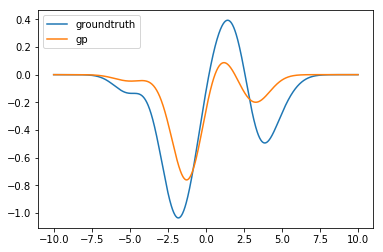

In [17]:
actions = np.linspace(-10.0,10.0,1000)

def plot_errors(m,gps):
    mus1 = []
    mus2 = []
    for a in actions:
        out1 = opt.integrate_dim(m, SDIM, a, b,B)
        mus1.append(out1[0])
    for i, gp in enumerate(gps):
        mus2 = []
        for a in actions:
            out2 = opt.integrate_dim(gp, SDIM, a, b,B)
            mus2.append(out2[0])
        plt.clf()
        plt.title("Integral Estimate - 3 Sdim - 1 Adim -Iteration %d" % i)
        plt.plot(actions, mus1, 'r', lw=2)
        plt.plot(actions, mus2, 'b', lw=2)
        plt.ylabel('integral of f(s,a)ds')
        plt.xlabel('actions')
        plt.savefig("./imgs/%i.png" % i)

INDEX = -1
def plot_error(m,gp):
    mus = np.array([])
    preds = np.array([])
    for a in actions:
        mus = np.append(mus,opt.integrate_dim(m,SDIM, a, b,B)[0])
        preds = np.append(preds,opt.integrate_dim(gp,SDIM, a, b,B)[0])
    print actions[mus.argmax()], mus.max()
    print actions[preds.argmax()], preds.max()
    plt.plot(actions, mus,label='groundtruth')
    plt.plot(actions, preds,label='gp')
    plt.legend(loc='upper left')
    plt.show()
plot_error(m,gps[3])
# plot_errors(m,gps)

[ 0.93252002 -3.08746779] 0.4261793495890401
[ 0.93252002 -3.08746779] 0.40304933998082754


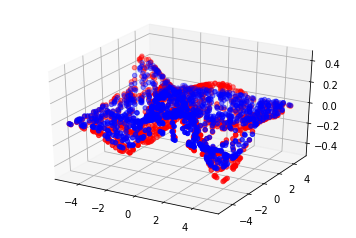

In [10]:
actions = np.random.uniform(ABOUNDS[0],ABOUNDS[1], (1000, ADIM))

def plot_3d(m,gp):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    mus = np.array([])
    preds = np.array([])
    for a in actions:
        mus = np.append(mus,opt.integrate_dim(m,SDIM, a, b,B)[0])
        preds = np.append(preds,opt.integrate_dim(gp,SDIM, a, b,B)[0])
    print actions[mus.argmax()], mus.max()
    print actions[preds.argmax()], preds.max()
    ax.scatter(actions[:,0], actions[:,1], mus,c='r')
    ax.scatter(actions[:,0], actions[:,1], preds,c='b')
    plt.show()
plot_3d(m,gps[-1])

In [11]:
len(gps)

100

In [38]:
np.append(a,10.0)

array([ 2., 10.])